In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

import os

source_path = "/store/kruu/wake_encounter_simulations/t20_phi0_speed80_close_dist_theta_random"

# Encounter parameters

In [2]:
directories = sorted([d for d in os.listdir(os.path.join(source_path, "encounters")) if d.isdigit()])

dataframes = []

for dir_name in directories:
    file_path = os.path.join(source_path, "encounters", dir_name, "param.parquet")
    
    if os.path.exists(file_path):
        df = pd.read_parquet(file_path)
        df['simulation_index'] = int(dir_name)
        dataframes.append(df)

aggregated_params = pd.concat(dataframes, ignore_index=True)

In [3]:
aggregated_params

,wake_id,aircraft_type,crop_distance,speed,t_target,theta,phi,x_target,y_target,z_target,simulation_index
0,0,A320,1500.0,80,20,-83,0,2.462,-62,1973,0
1,0,A320,1500.0,80,20,-67,0,2.462,-62,1973,1
2,0,A320,1500.0,80,20,-30,0,2.462,-62,1973,10
3,0,A320,1500.0,80,20,29,0,2.462,-62,1973,11
4,0,A320,1500.0,80,20,-16,0,2.462,-62,1973,12
...,...,...,...,...,...,...,...,...,...,...,...
95,0,A320,1500.0,80,20,78,0,2.462,-62,1973,95
96,0,A320,1500.0,80,20,72,0,2.462,-62,1973,96
97,0,A320,1500.0,80,20,-34,0,2.462,-62,1973,97
98,0,A320,1500.0,80,20,-26,0,2.462,-62,1973,98


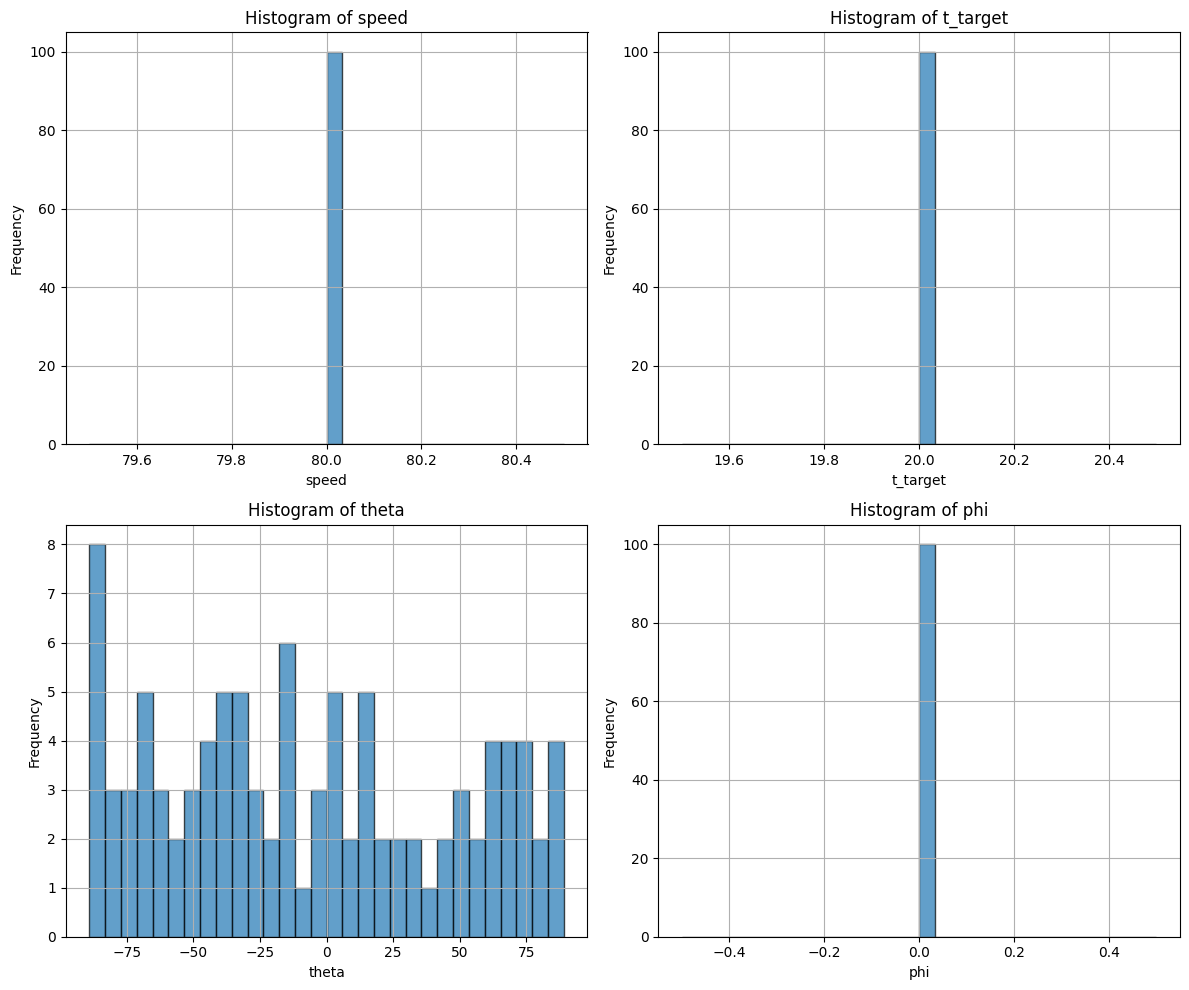

In [4]:
columns_to_plot = ['speed', 't_target', 'theta', 'phi']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to easily iterate through axes

for i, column in enumerate(columns_to_plot):
    if column in aggregated_params.columns:
        axes[i].hist(aggregated_params[column], bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Histogram of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True)
    else:
        print(f"Column {column} not found in dataframe.")

plt.tight_layout()
plt.show()


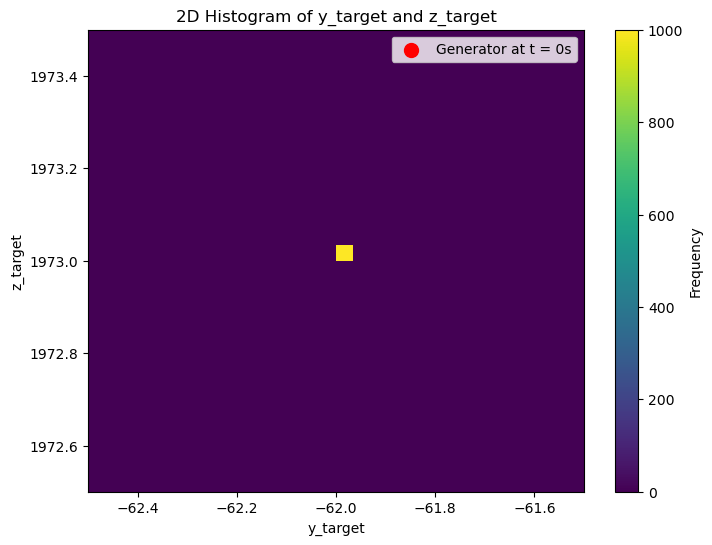

In [39]:
if 'y_target' in aggregated_params.columns and 'z_target' in aggregated_params.columns:
    plt.figure(figsize=(8, 6))
    plt.hist2d(
        aggregated_params['y_target'], 
        aggregated_params['z_target'], 
        bins=30, 
        cmap='viridis'
    )
    plt.colorbar(label='Frequency')
    plt.title('2D Histogram of y_target and z_target')
    plt.xlabel('y_target')
    plt.ylabel('z_target')
    plt.grid(False)
    
    plt.scatter(0, 2000, color='red', label='Generator at t = 0s', s=100)
    plt.legend(loc='upper right')
    plt.show()
else:
    print("Columns 'y_target' and/or 'z_target' not found in dataframe.")


# Wake parameters

In [5]:
sim = aggregated_params["wake_id"].unique()[0]

# Wake parameters
wake_params = pd.read_parquet(os.path.join(source_path, "wakes", str(sim), "param.parquet"))
wake_params

,run_id,alt_aircraft,spread,step,wind_vel,wind_dir,temp,p_ref,tke,speed,mass,wingspan,wind_vertical_vel,alt_sensor,qq,gpa
0,0,2000.0,1000,10,2.0,130.0,288.15,101300.0,10.0,100.0,136000.0,47.3,0.0,10.0,0.05,0.0


In [6]:
wake_df = pd.read_parquet(os.path.join(source_path, "wakes", str(sim), "wakes_df.parquet"))

In [7]:
# Calulate the distance between the crossing point and the wake tube center at the gate x = -1 (in meters)
for i, row in aggregated_params.iterrows():
    wake = wake_df.query(f"t == {row['t_target']}")
    aggregated_params.loc[i, 'distance'] = np.sqrt((row['y_target'] - wake['yr'].values[0])**2 + (row['z_target'] - wake['zr'].values[0])**2)

aggregated_params

,wake_id,aircraft_type,crop_distance,speed,t_target,theta,phi,x_target,y_target,z_target,simulation_index,distance
0,0,A320,1500.0,80,20,-83,0,2.462,-62,1973,0,22.159114
1,0,A320,1500.0,80,20,-67,0,2.462,-62,1973,1,22.159114
2,0,A320,1500.0,80,20,-30,0,2.462,-62,1973,10,22.159114
3,0,A320,1500.0,80,20,29,0,2.462,-62,1973,11,22.159114
4,0,A320,1500.0,80,20,-16,0,2.462,-62,1973,12,22.159114
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,A320,1500.0,80,20,78,0,2.462,-62,1973,95,22.159114
96,0,A320,1500.0,80,20,72,0,2.462,-62,1973,96,22.159114
97,0,A320,1500.0,80,20,-34,0,2.462,-62,1973,97,22.159114
98,0,A320,1500.0,80,20,-26,0,2.462,-62,1973,98,22.159114


# Results

In [8]:
directories = sorted([d for d in os.listdir(os.path.join(source_path, "encounters")) if d.isdigit()])

results = {}

for dir_name in directories:
    results_file_path = os.path.join(source_path, "encounters", dir_name, "results.parquet")
    encounter_file_path = os.path.join(source_path, "encounters", dir_name, "encounter_df.parquet")
    
    if os.path.exists(results_file_path):
        df = pd.read_parquet(results_file_path)
        enc = pd.read_parquet(encounter_file_path)
        df.index = df.index + enc.index[0] + 1 # +1 because the results are calculated for t=1 and not t=0
        results[int(dir_name)] = df

In [9]:
forces = ["C_L", "C_D", "C_Y"] #Lift, Drag, Side
moments = ["C_l", "C_m", "C_n"] #rolling, pitching, yawing

sim_to_plot = np.random.choice(list(results.keys()), size=5, replace=False)
labels = sim_to_plot

# sim_to_plot = aggregated_params.query("80 <= abs(theta)").simulation_index.values
# labels = aggregated_params.query("80 <= abs(theta)").simulation_index.values

# List of dataframes
dataframes = [results[i] for i in sim_to_plot]

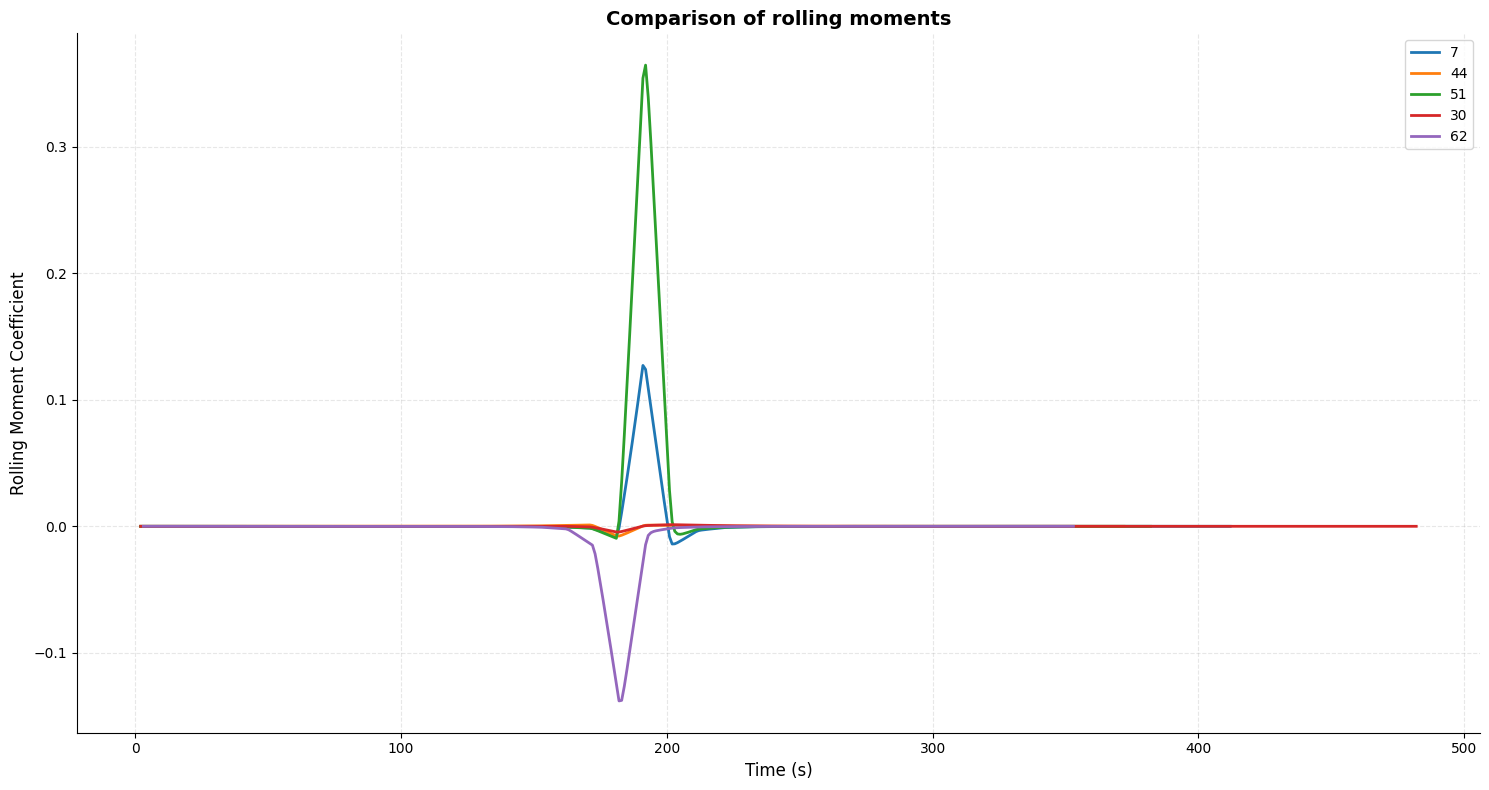

In [10]:
plt.figure(figsize=(15, 8))
plt.grid(alpha=0.3, linestyle='--')

for i, (df, label) in enumerate(zip(dataframes, labels)):
    plt.plot(df["C_l"], label=label, linewidth=2)
    # plt.plot(df["Rolling"], label=label, linewidth=2)

plt.legend(title="Scenarios", fontsize='medium', frameon=False)
plt.legend()

# Add labels and title for better clarity
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Rolling Moment Coefficient", fontsize=12)
plt.title("Comparison of rolling moments", fontsize=14, fontweight='bold')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 

# Show the plot
plt.show()


****
# RMC against parameter
****

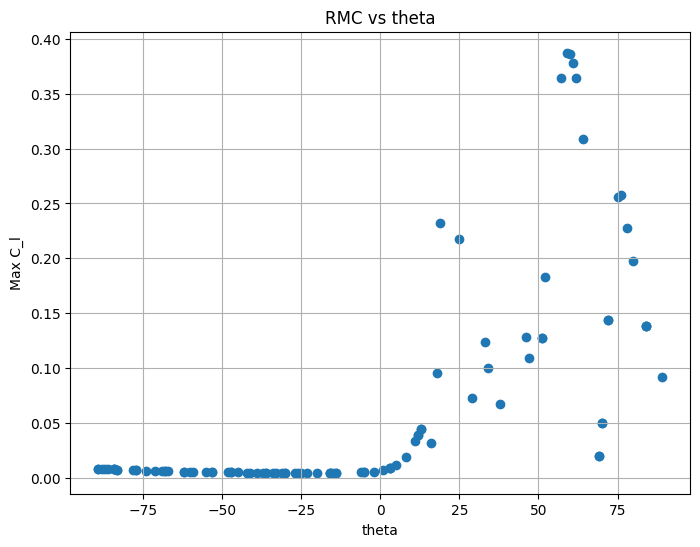

In [11]:
param_to_plot = "theta"

max_c_l_values = {k: v["C_l"].abs().max() for k, v in results.items()}
# max_c_l_values = {k: v["Rolling"].abs().max() for k, v in results.items()}
params = {k: aggregated_params.query(f"simulation_index == {k}")[f"{param_to_plot}"].values[0] for k in max_c_l_values.keys()}

#plot max c_l vs speed
plt.figure(figsize=(8, 6))
plt.scatter(params.values(), max_c_l_values.values())
plt.xlabel(f"{param_to_plot}")
plt.ylabel("Max C_l")
plt.title(f"RMC vs {param_to_plot}")
plt.grid(True)
plt.show()


# Severe encounters

In [12]:
# Calulation of quantiles on the maximum RMC of each simulation
coef = "C_l"

# all_c_l_values = pd.concat([df['C_l'].abs() for df in results.values()])
max_c_l_values = pd.Series([df[coef].abs().max() for df in results.values()])
quantiles = max_c_l_values.quantile([0.25, 0.5, 0.75, 0.90, 0.95, 0.99])
print(quantiles)

keys_above_quantile = [
    key for key, df in results.items()
    if (df[coef].abs() >= max_c_l_values.quantile(0.90)).any()
]

# keys_above_quantile = [
#     key for key, df in results.items()
#     if (0.1 <= df[coef].abs().max() <= 0.3)
# ]

severe_encounter = aggregated_params.query(f"simulation_index in {keys_above_quantile}")

0.25    0.004643
0.50    0.007419
0.75    0.092924
0.90    0.218963
0.95    0.311768
0.99    0.385853
dtype: float64


## Each conditional marginals

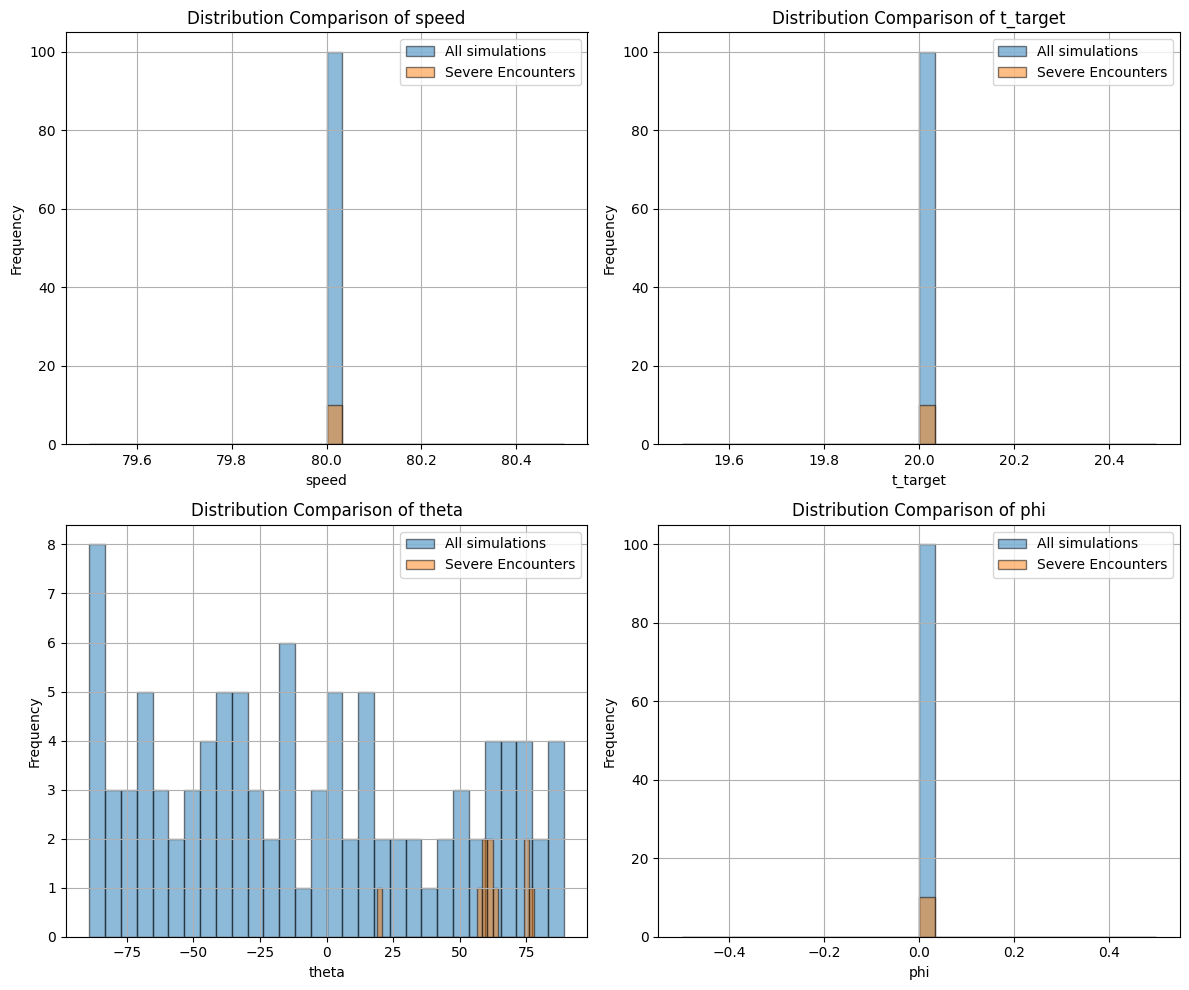

In [13]:
columns_to_plot = ['speed', 't_target', 'theta', 'phi']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to easily iterate through axes

for i, column in enumerate(columns_to_plot):
    if column in aggregated_params.columns and column in severe_encounter.columns:
        axes[i].hist(aggregated_params[column], bins=30, alpha=0.5, label='All simulations', edgecolor='black')
        axes[i].hist(severe_encounter[column], bins=30, alpha=0.5, label='Severe Encounters', edgecolor='black')
        axes[i].set_title(f'Distribution Comparison of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].legend(loc='upper right')
        axes[i].grid(True)
    else:
        print(f"Column {column} not found in dataframe.")

plt.tight_layout()
plt.show()

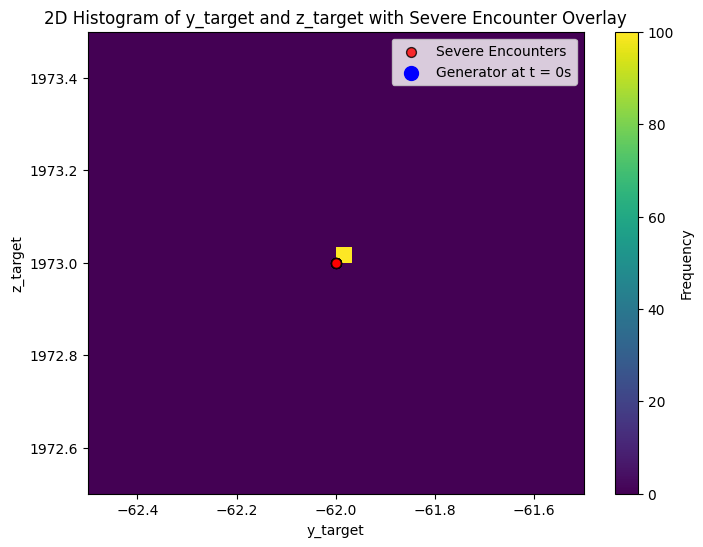

In [14]:
if 'y_target' in aggregated_params.columns and 'z_target' in aggregated_params.columns:
    plt.figure(figsize=(8, 6))
    
    # 2D Histogram for All Simulations
    plt.hist2d(
        aggregated_params['y_target'], 
        aggregated_params['z_target'], 
        bins=30, 
        cmap='viridis'
    )
    plt.colorbar(label='Frequency')
    plt.title('2D Histogram of y_target and z_target with Severe Encounter Overlay')
    plt.xlabel('y_target')
    plt.ylabel('z_target')
    plt.grid(False)
    
    # Scatter plot for Severe Encounters
    if 'y_target' in severe_encounter.columns and 'z_target' in severe_encounter.columns:
        plt.scatter(
            severe_encounter['y_target'], 
            severe_encounter['z_target'], 
            color='red', 
            label='Severe Encounters', 
            s=50, 
            alpha=0.8, 
            edgecolor='black'
        )
    
    # Mark the generator position
    plt.scatter(0, 2000, color='blue', label='Generator at t = 0s', s=100)
    
    # Add legend
    plt.legend(loc='upper right')
    plt.show()
else:
    print("Columns 'y_target' and/or 'z_target' not found in dataframe.")

# Pairwise dependency

/tmp/ipykernel_958400/1196502612.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  severe_encounter['Type'] = 'Severe Encounters'


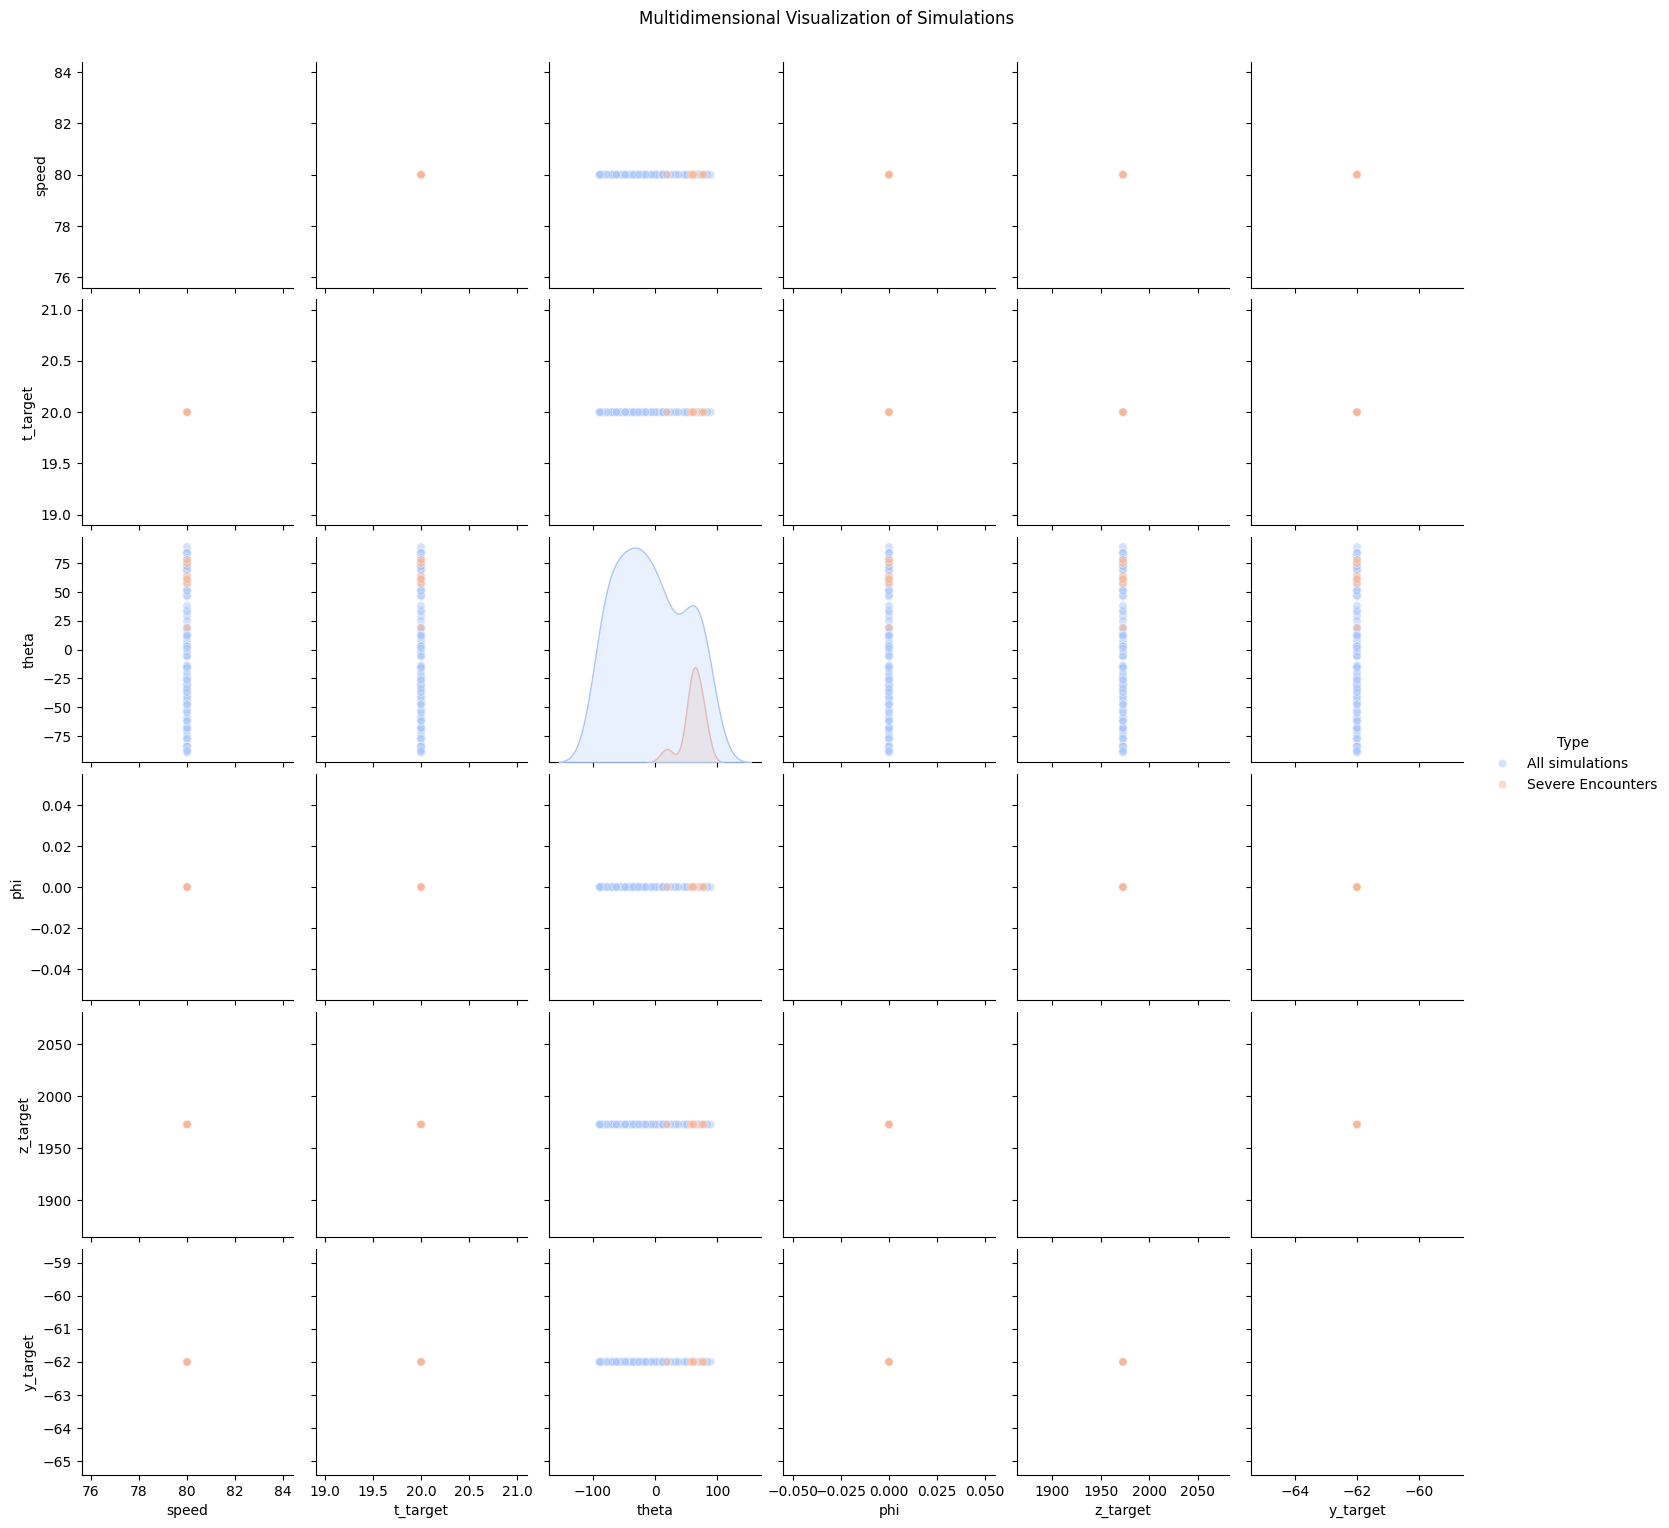

In [15]:
columns_to_plot = ['speed', 't_target', 'theta', 'phi', "z_target", "y_target"]

# Initialize a pair plot for multidimensional visualization
# Combine the two datasets into one for easier visualization
aggregated_params['Type'] = 'All simulations'
severe_encounter['Type'] = 'Severe Encounters'
combined_data = pd.concat([aggregated_params, severe_encounter])

# Use seaborn pairplot to visualize pairwise interactions
sns.pairplot(combined_data, vars=columns_to_plot, hue="Type", palette="coolwarm", diag_kind="kde", plot_kws={'alpha': 0.5})
plt.suptitle("Multidimensional Visualization of Simulations", y=1.02)  # Adjust title position
plt.show()


## 3D scatter plot

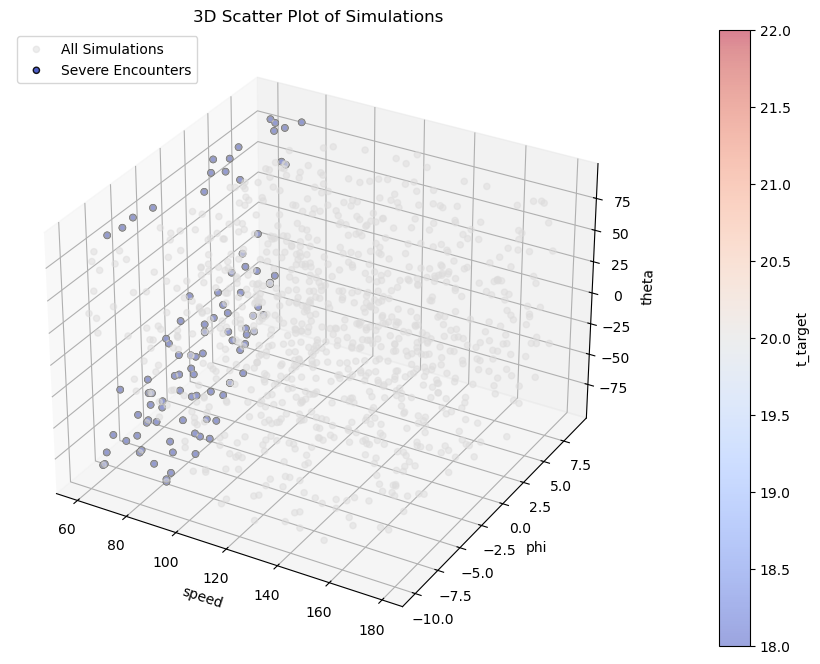

In [54]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Select three variables for the 3D scatter plot
x_col = 'speed'
y_col = 'phi'
z_col = 'theta'
color_col = 't_target'  # Optional: Use for coloring based on severity or another feature

# Create the 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot for all simulations
sc = ax.scatter(aggregated_params[x_col], 
                aggregated_params[y_col], 
                aggregated_params[z_col], 
                c=aggregated_params[color_col], 
                cmap='coolwarm', alpha=0.5, label='All Simulations')

# Plot for severe encounters
sc_severe = ax.scatter(severe_encounter[x_col], 
                       severe_encounter[y_col], 
                       severe_encounter[z_col], 
                       c=severe_encounter[color_col], 
                       cmap='coolwarm', edgecolor='black', alpha=0.9, label='Severe Encounters')

# Add colorbar for the color scale
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label(color_col)

# Add labels and title
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)
ax.set_zlabel(z_col)
ax.set_title('3D Scatter Plot of Simulations')
ax.legend(loc='upper left')

plt.show()

## Projection through TSNE/PCA

/tmp/ipykernel_2724657/3518859495.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Type'] = 'Severe Encounters'


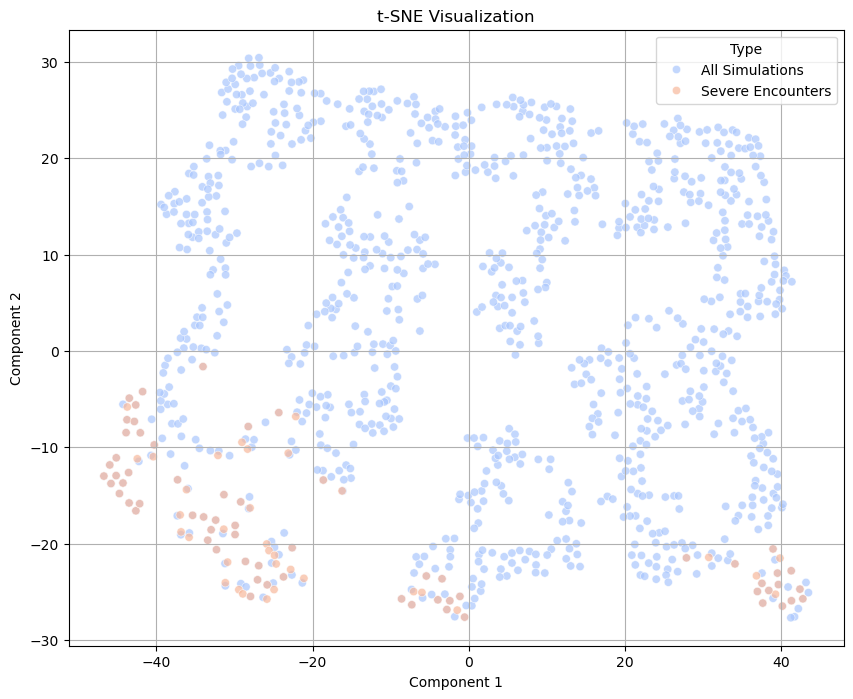

In [55]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_dimensionality_reduction(data1, data2, method='pca', features=None):
    """
    Plots 2D dimensionality reduction using PCA or t-SNE.
    
    Parameters:
        data1: DataFrame for 'All Simulations'.
        data2: DataFrame for 'Severe Encounters'.
        method: 'pca' or 'tsne' for dimensionality reduction.
        features: List of features to include in dimensionality reduction.
    """
    # Combine datasets for visualization
    data1['Type'] = 'All Simulations'
    data2['Type'] = 'Severe Encounters'
    combined_data = pd.concat([data1, data2])

    # Select only the desired features
    if features is None:
        features = ['speed', 't_target', 'theta', 'phi']
    X = combined_data[features]
    y = combined_data['Type']

    # Perform dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
        title = 'PCA Visualization'
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
        title = 't-SNE Visualization'
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    X_reduced = reducer.fit_transform(X)

    # Create a DataFrame for the reduced data
    reduced_df = pd.DataFrame(X_reduced, columns=['Component 1', 'Component 2'])
    reduced_df['Type'] = y.values

    # Plot the results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=reduced_df,
        x='Component 1',
        y='Component 2',
        hue='Type',
        palette='coolwarm',
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(title='Type', loc='best')
    plt.grid(True)
    plt.show()
    
plot_dimensionality_reduction(aggregated_params, severe_encounter, method='tsne', features=['speed', 't_target', 'theta', 'phi', 'y_target', 'z_target'])

## PLots of severe encounter compared to crossing point in the gate.

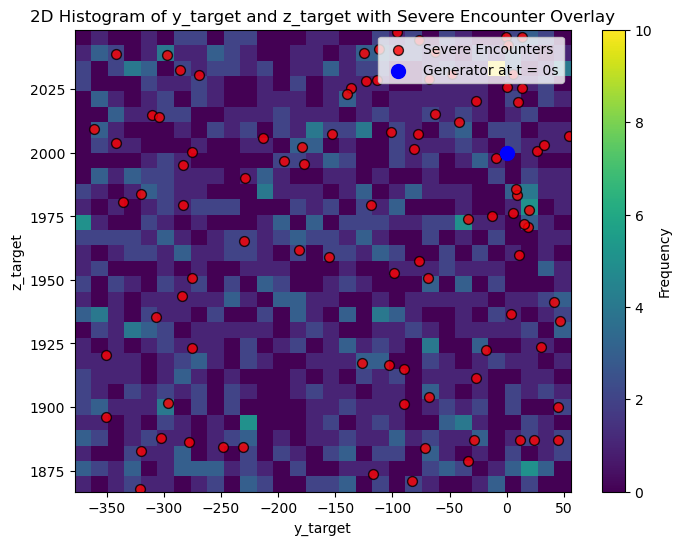

## Plots of coefficients

In [46]:
sim_to_plot = np.random.choice(keys_above_quantile, size=10, replace=False)
labels = sim_to_plot

# List of dataframes
dataframes = [results[i] for i in sim_to_plot]

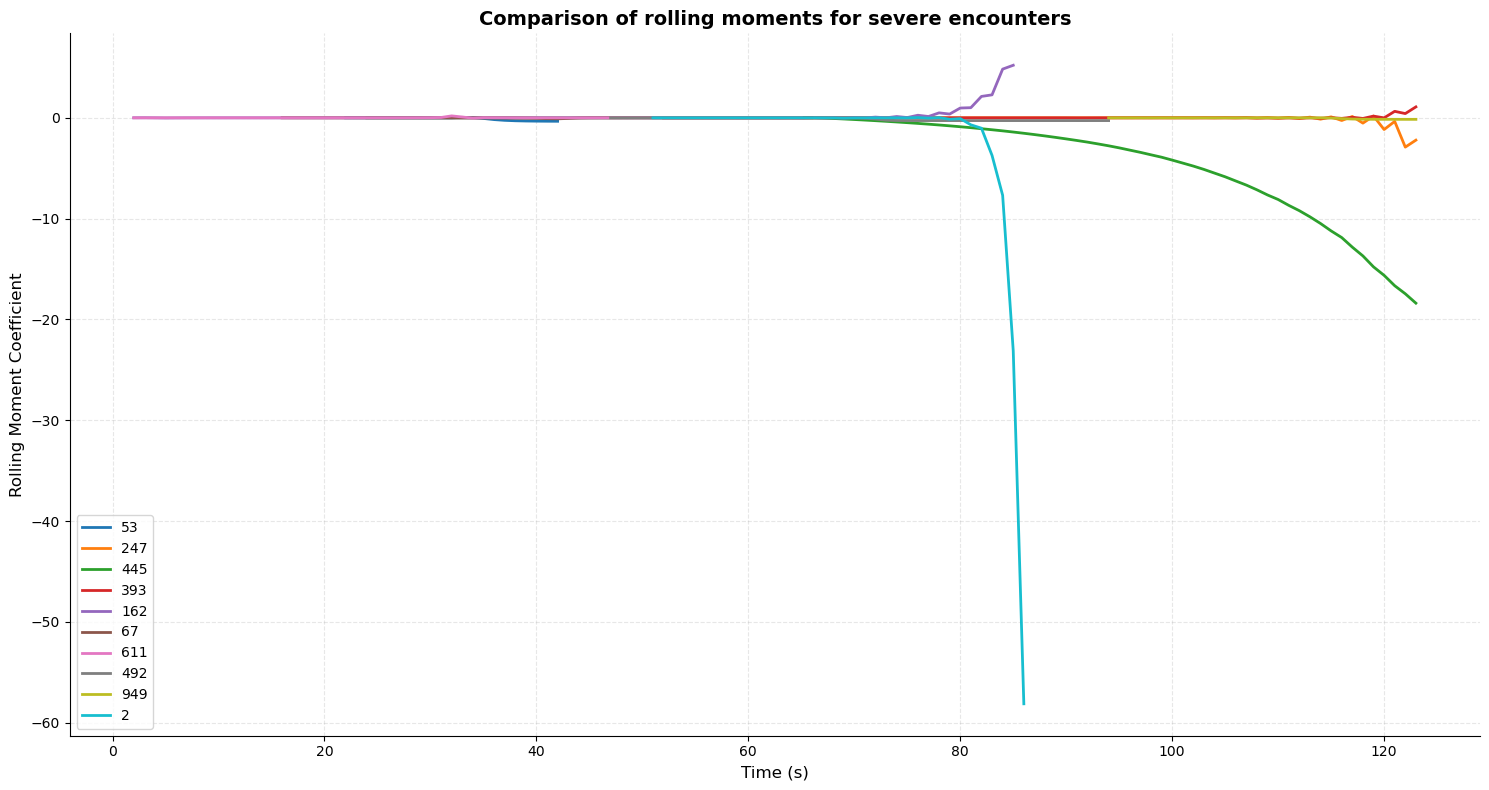

In [47]:
plt.figure(figsize=(15, 8))
plt.grid(alpha=0.3, linestyle='--')

for i, (df, label) in enumerate(zip(dataframes, labels)):
    plt.plot(df["C_l"], label=label, linewidth=2)

plt.legend(title="Scenarios", fontsize='medium', frameon=False)
plt.legend()

# Add labels and title for better clarity
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Rolling Moment Coefficient", fontsize=12)
plt.title("Comparison of rolling moments for severe encounters", fontsize=14, fontweight='bold')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 

# Show the plot
plt.show()

In [36]:
aggregated_params.query("simulation_index == 474")

,wake_id,aircraft_type,crop_distance,speed,t_target,theta,phi,x_target,y_target,z_target,simulation_index
417,0,A320,1500.0,83,69,-2,8,-1.0,-83.094356,1870.814224,474


# Load Factor

In [38]:
mA320 = 70000
g = 9.81

max_load = {i:(df['Lift']/(mA320*g)).max() for i, df in results.items()}

In [39]:
#calulation of max load factors

max_load = pd.Series([(df['Lift']/(mA320*g)).max() for df in results.values()])
quantiles = max_load.quantile([0.25, 0.5, 0.75, 0.90, 0.95, 0.99])
print(quantiles)

keys_above_quantile_load = [
    key for key, df in results.items()
    if ((df['Lift']/(mA320*g)) >= max_load.quantile(0.90)).any()
]

severe_encounter_load = aggregated_params.query(f"simulation_index in {keys_above_quantile_load}")

0.25    0.658886
0.50    1.147515
0.75    1.803845
0.90    2.214142
0.95    2.377395
0.99    2.787237
dtype: float64


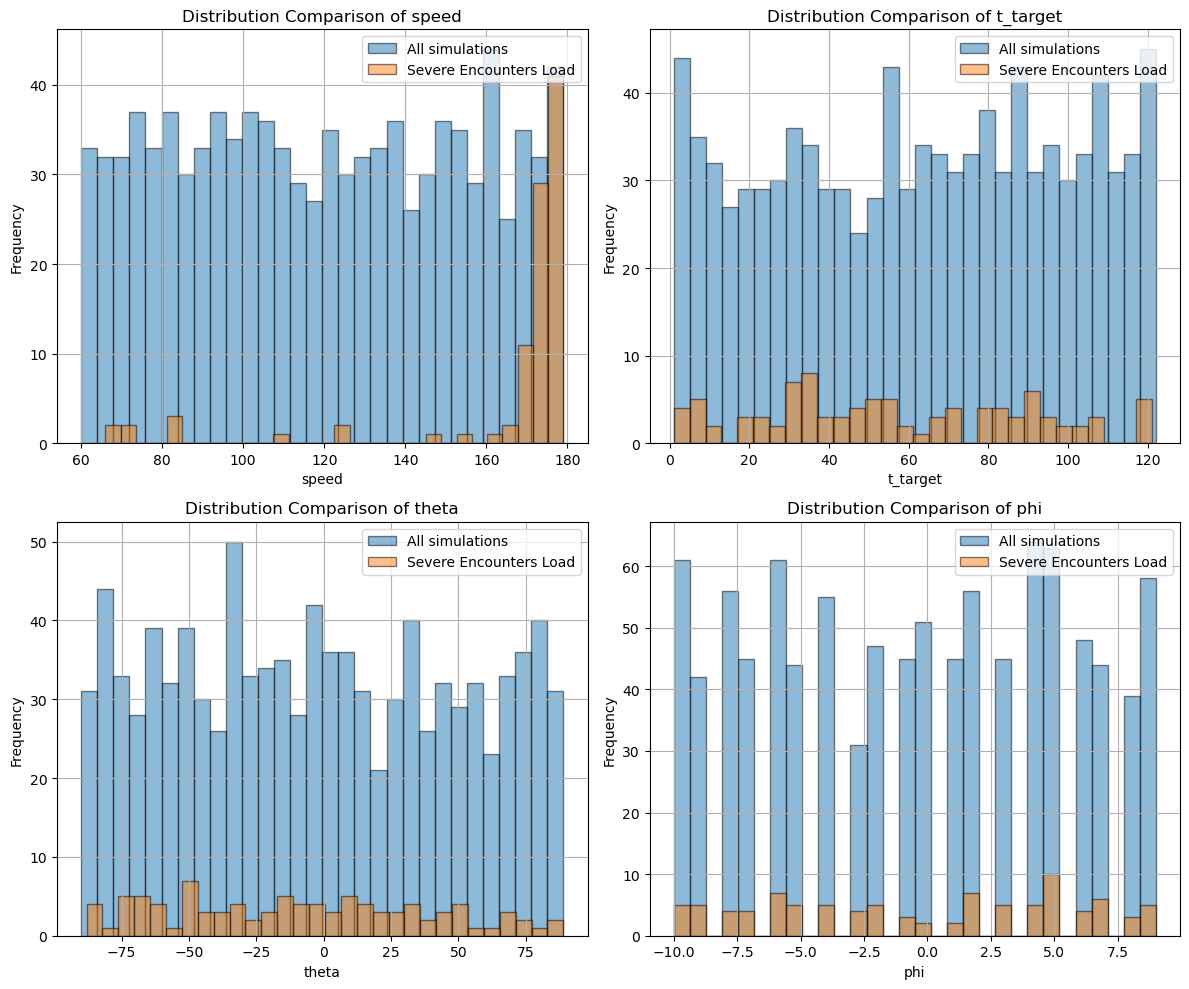

In [40]:
columns_to_plot = ['speed', 't_target', 'theta', 'phi']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to easily iterate through axes

for i, column in enumerate(columns_to_plot):
    if column in aggregated_params.columns and column in severe_encounter_load.columns:
        axes[i].hist(aggregated_params[column], bins=30, alpha=0.5, label='All simulations', edgecolor='black')
        axes[i].hist(severe_encounter_load[column], bins=30, alpha=0.5, label='Severe Encounters Load', edgecolor='black')
        axes[i].set_title(f'Distribution Comparison of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].legend(loc='upper right')
        axes[i].grid(True)
    else:
        print(f"Column {column} not found in dataframe.")

plt.tight_layout()
plt.show()

In [41]:
sim_to_plot_load = np.random.choice(keys_above_quantile_load, size=10, replace=False)
labels_load = sim_to_plot_load

# List of dataframes
dataframes_load= [results[i] for i in sim_to_plot_load]

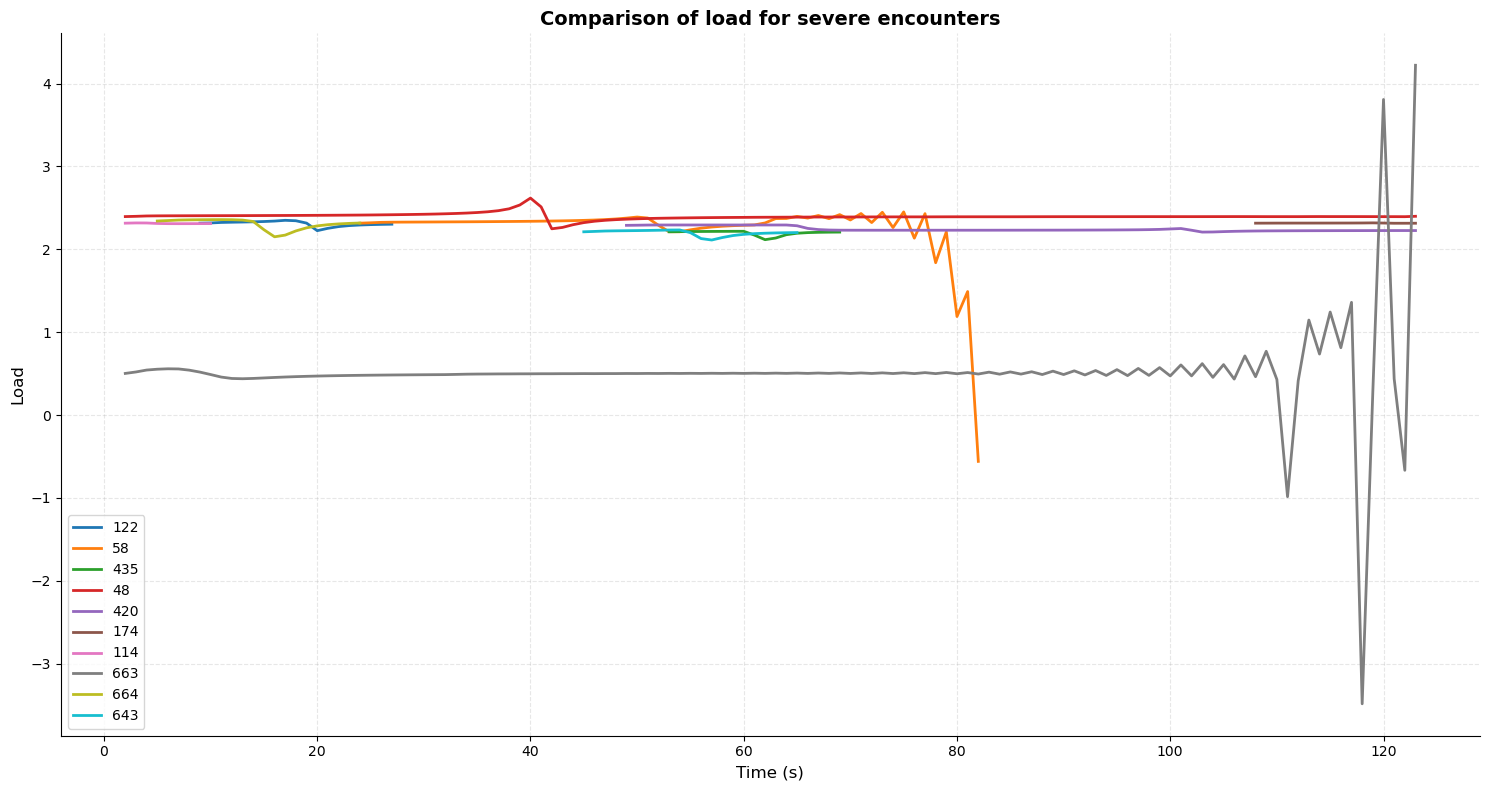

In [42]:
plt.figure(figsize=(15, 8))
plt.grid(alpha=0.3, linestyle='--')

for i, (df, label) in enumerate(zip(dataframes_load, labels_load)):
    plt.plot((df['Lift']/(mA320*g)), label=label, linewidth=2)

plt.legend(title="Scenarios", fontsize='medium', frameon=False)
plt.legend()

# Add labels and title for better clarity
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Load", fontsize=12)
plt.title("Comparison of load for severe encounters", fontsize=14, fontweight='bold')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 

# Show the plot
plt.show()

In [43]:
aggregated_params.query("simulation_index == 474")

,wake_id,aircraft_type,crop_distance,speed,t_target,theta,phi,x_target,y_target,z_target,simulation_index
417,0,A320,1500.0,83,69,-2,8,-1.0,-83.094356,1870.814224,474


In [45]:
aggregated_params.query("simulation_index == 58")

,wake_id,aircraft_type,crop_distance,speed,t_target,theta,phi,x_target,y_target,z_target,simulation_index
534,0,A320,1500.0,176,50,16,-8,-1.0,-275.240245,1923.274283,58


# Linear Regression

Predict the max RMC depending on:
- speed
- t_target
- theta
- phi
- minimum distance to wake (not necessarily at t_target)

In [32]:
target = {i:df['C_l'].abs().max() for i, df in results.items()}
data = aggregated_params[["speed", "t_target", "theta", "phi", "simulation_index"]]

min_dist_wake = {}
for i in data.simulation_index.unique():
    temp = pd.read_parquet(os.path.join(source_path, "encounters", str(i), "encounter_df.parquet"))
    min_dist_wake[i] = min(temp.dist_left_wake.min(), temp.dist_right_wake.min())
    
data['min_dist_wake'] = data['simulation_index'].map(min_dist_wake)
data['target'] = data['simulation_index'].map(target)
data

/tmp/ipykernel_2724657/1659442191.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['min_dist_wake'] = data['simulation_index'].map(min_dist_wake)
/tmp/ipykernel_2724657/1659442191.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['simulation_index'].map(target)


,speed,t_target,theta,phi,simulation_index,min_dist_wake,target
0,152,20,29,-1,0,68.434211,0.000122
1,73,20,19,-4,1,72.247593,0.000196
2,116,20,78,-5,10,103.364824,0.002060
3,179,20,-43,2,100,61.000928,0.000071
4,120,20,46,-3,101,86.011738,0.000438
...,...,...,...,...,...,...,...
995,112,20,39,-5,995,98.903433,0.000301
996,144,20,13,2,996,35.477987,0.000078
997,74,20,-33,-8,997,148.950403,0.000122
998,109,20,76,1,998,57.611243,0.016466


In [33]:
#droping missing values if needed
data = data.dropna()

In [34]:
model_lm = smf.ols(
    "target ~ speed + t_target + theta + phi + min_dist_wake", 
    data, 
)

res_lm = model_lm.fit()
res_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     7.388
Date:                Mon, 24 Mar 2025   Prob (F-statistic):           7.29e-06
Time:                        09:23:21   Log-Likelihood:                 2540.6
No. Observations:                1000   AIC:                            -5071.
Df Residuals:                     995   BIC:                            -5047.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.992e-05   6.02e-06      4.972      0.000    1.81e-05    4.17e-05
speed          -5.35e-05   1.73e-05     -3.092      0.002   -8.74e-05   -1.95e-05
t_target          0.0006      0.000      4.972      0.000       0.000       0.001
theta          3.292e-05   1.19e-05      2.759      0.006    9.51e-06    5.63e-05
phi               0.0002      0.000      1.889      0.059   -8.94e-06       0.000
min_dist_wake -1.651e-05   9.71e-06     -1.700      0.089   -3.56e-05    2.55e-06
==============================================================================
Omnibus:                     1699.978   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           845398.446
Skew:                          11.133   Prob(JB):                         0.00
Kurtosis:                     143.691   Cond. No.                     2.25e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.16e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""